# Predictions statistics

Let's analyse the predictions made on our test datasplit.

**Note** To run this notebook you previously have to run and save the predictions on a test dataset **with ground-truth labels**. See the Datasplit section in [3.0 notebook](./3.0-Computing_predictions.ipynb#Predicting-a-datasplit-txt-file) for reference.


In [2]:
import os
import json
import numpy as np

from imgclas.data_utils import load_image, load_class_names
from imgclas import paths, plot_utils

import warnings
warnings.filterwarnings("ignore") # To ignore UndefinedMetricWarning: [Recall/Precision/F-Score] is ill-defined and being set to 0.0 in labels with no [true/predicted] samples.

# User parameters to set
TIMESTAMP = '2021-10-29_Xception_Tortuosidad_50ep'           # timestamp of the model
SPLIT_NAME = 'test'                   # dataset split to predict
MODEL_NAME = 'final_model.h5'         # model to use to make the mediction
TOP_K = 2                             # number of top classes predictions to save

# Set the timestamp
paths.timestamp = TIMESTAMP

# Load clas names
class_names = load_class_names(splits_dir=paths.get_ts_splits_dir())

# Load back the predictions
pred_path = os.path.join(paths.get_predictions_dir(), '{}+{}+top{}.json'.format(MODEL_NAME, SPLIT_NAME, TOP_K))
with open(pred_path) as f:
    pred_dict = json.load(f)

Loading class names...


## Computing the metrics

Check [sklearn](https://scikit-learn.org/stable/modules/classes.html#classification-metrics) for more classification metrics.

In [3]:
from imgclas import test_utils
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score


true_lab, pred_lab = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])

top1 = test_utils.topK_accuracy(true_lab, pred_lab, K=1)
# top5 = test_utils.topK_accuracy(true_lab, pred_lab, K=5)

print('Top1 accuracy: {:.1f} %'.format(top1 * 100))
# print('Top5 accuracy: {:.1f} %'.format(top5 * 100))

labels = range(len(class_names))
print('\n')
print('Micro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro recall (no labels): {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted recall: {:.1f} %'.format(100 * recall_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro precision (no labels): {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted precision: {:.1f} %'.format(100 * precision_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

print('\n')
print('Micro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='micro')))
print('Macro F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='macro')))
print('Macro F1 score (no labels): {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], average='macro')))
print('Weighted F1 score: {:.1f} %'.format(100 * f1_score(true_lab, pred_lab[:, 0], labels=labels, average='weighted')))

Top1 accuracy: 85.7 %


Micro recall: 85.7 %
Macro recall: 83.3 %
Macro recall (no labels): 83.3 %
Weighted recall: 85.7 %


Micro precision: 85.7 %
Macro precision: 90.0 %
Macro precision (no labels): 90.0 %
Weighted precision: 88.6 %


Micro F1 score: 85.7 %
Macro F1 score: 84.4 %
Macro F1 score (no labels): 84.4 %
Weighted F1 score: 85.1 %


## Computing the confusion matrix

In [4]:
import matplotlib.pylab as plt
import seaborn
from sklearn.metrics import confusion_matrix


def plt_conf_matrix(conf_mat, labels=False):
    
    fig = plt.figure(figsize=(20, 20))
    hm = seaborn.heatmap(conf_mat, annot=False, square=True, cbar_kws={'fraction':0.046, 'pad':0.04},
                         xticklabels=labels, yticklabels=labels)
    fontsize = None
    hm.yaxis.set_ticklabels(hm.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    hm.xaxis.set_ticklabels(hm.xaxis.get_ticklabels(), rotation=90, ha='right', fontsize=fontsize)

    plt.ylabel('True label')
    plt.xlabel('Predicted label')

### Standard confusion matrix

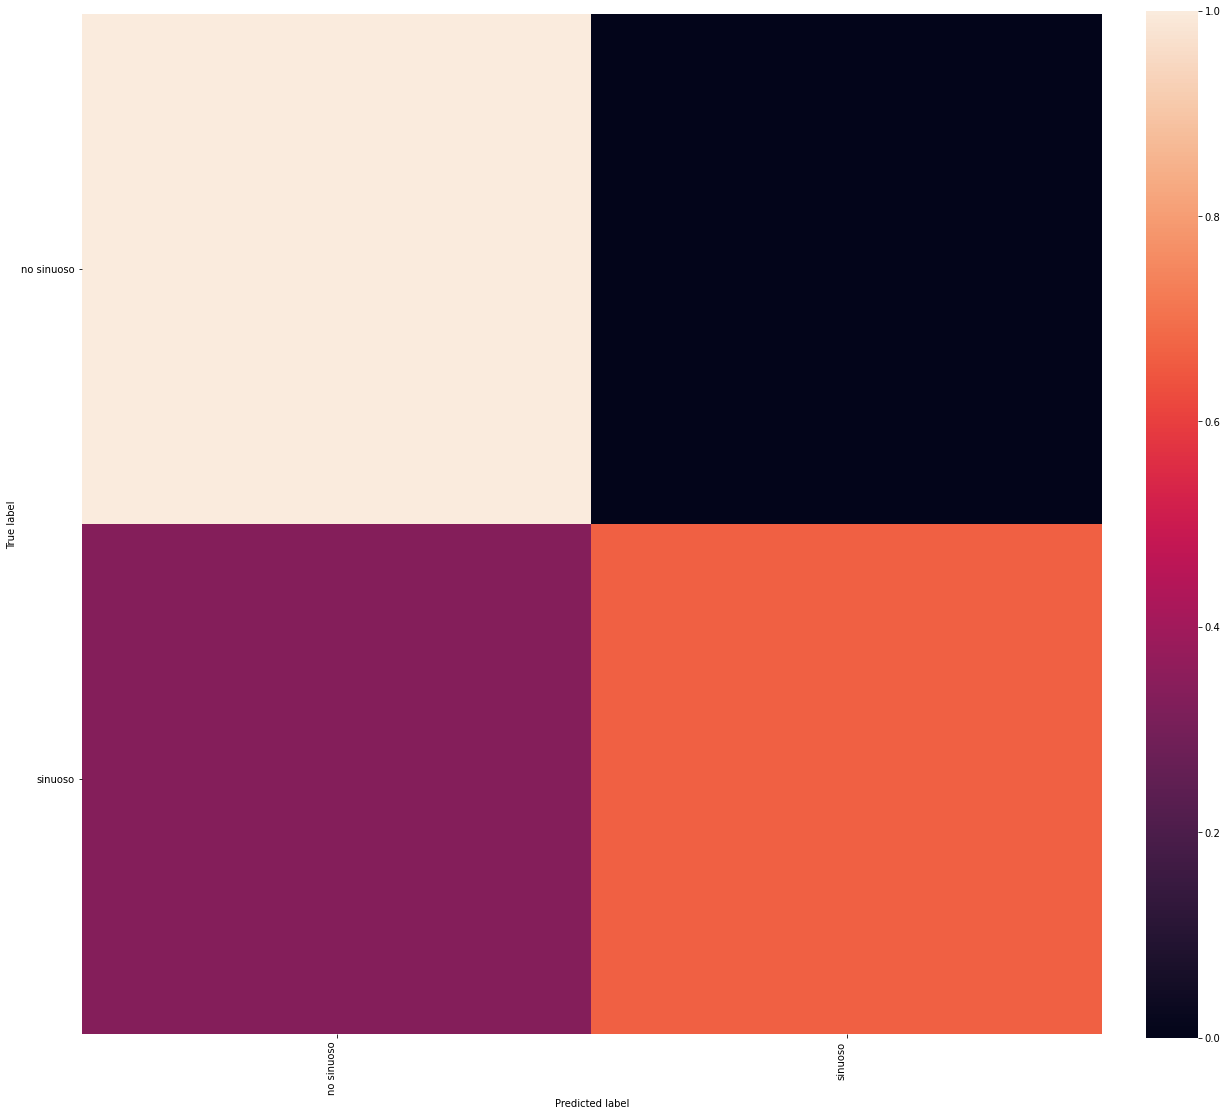

In [5]:
y_true, y_pred = np.array(pred_dict['true_lab']), np.array(pred_dict['pred_lab'])[:, 0]
conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=None)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names)

### Weighted confusion matrix
We weight each count in the confusion matrix by the probability of the prediction.

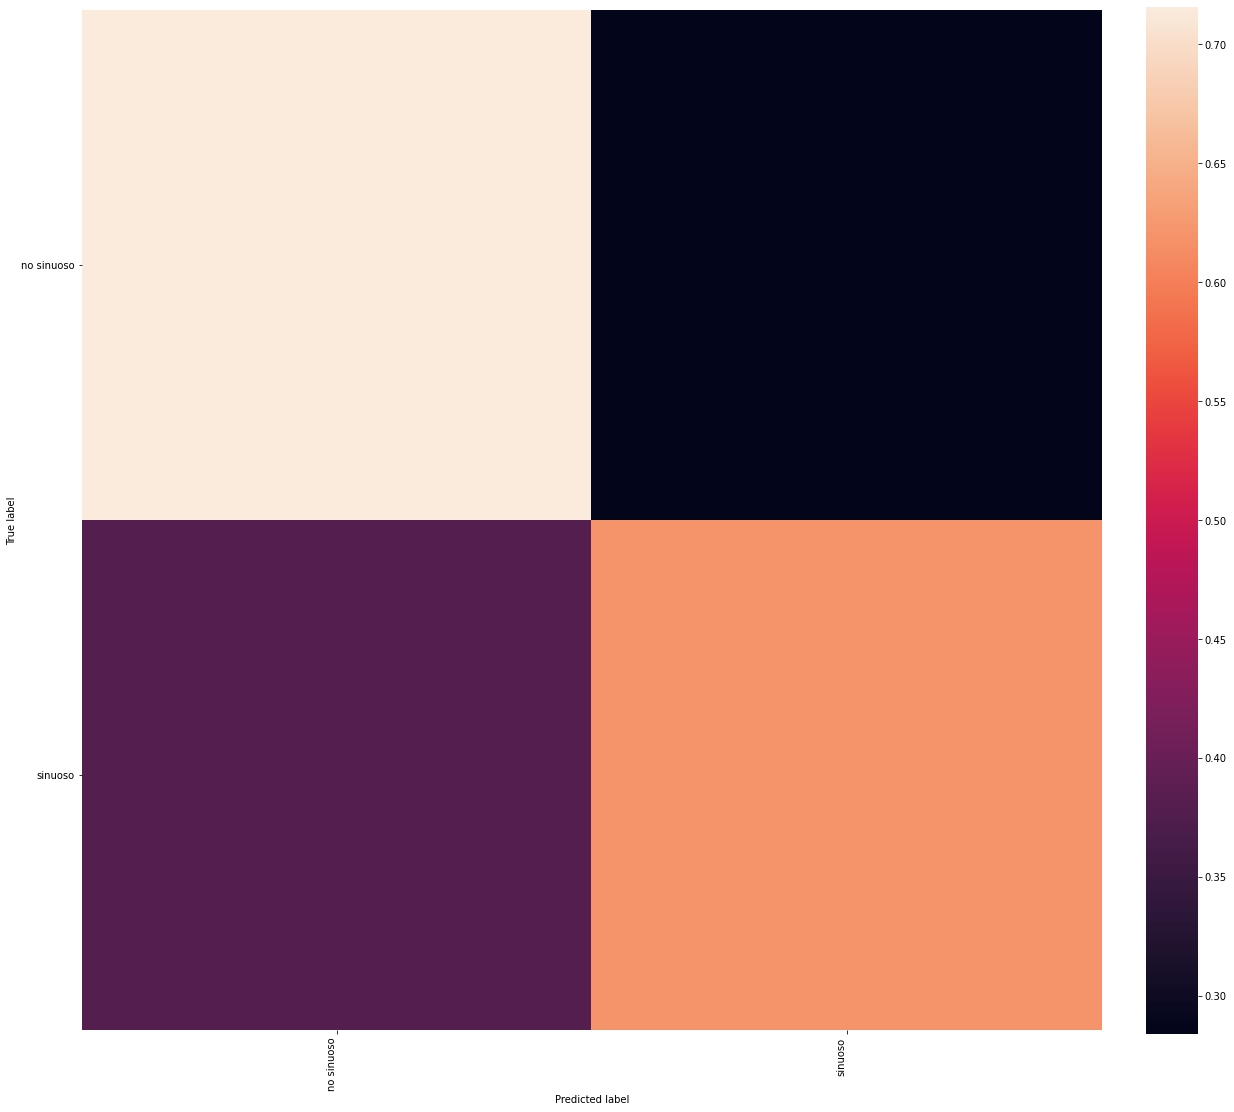

In [6]:
y_pred = np.array(pred_dict['pred_lab'])
y_true = np.repeat(np.array(pred_dict['true_lab']), y_pred.shape[1])
y_pred = y_pred.flatten()
weights = np.array(pred_dict['pred_prob']).flatten()

conf_mat = confusion_matrix(y_true, y_pred, labels=range(len(class_names)), sample_weight=weights)
normed_conf = conf_mat / np.sum(conf_mat, axis=1)[:, np.newaxis]

# plt_conf_matrix(conf_mat)
plt_conf_matrix(normed_conf, labels=class_names)